In [851]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [852]:
data = pd.read_csv('Kobe.csv')

In [853]:
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [854]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**

4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC

5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

#### Начнем с проверки датасета на пустые значения

Видим, что целевое поле shot_made_flag не заполнено у 5000 записей. По условиям задания в kaggle.com они были удалены, чтобы впоследствии проверить эффективность представленных моделей (валидационные данные).

У нас результирующих значений нет, поэтому уберем неполные записи из нашего датасета.

In [855]:
data = data[data['shot_made_flag'].notna()]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         25697 non-null  object 
 1   combined_shot_type  25697 non-null  object 
 2   game_event_id       25697 non-null  int64  
 3   game_id             25697 non-null  int64  
 4   lat                 25697 non-null  float64
 5   loc_x               25697 non-null  int64  
 6   loc_y               25697 non-null  int64  
 7   lon                 25697 non-null  float64
 8   minutes_remaining   25697 non-null  int64  
 9   period              25697 non-null  int64  
 10  playoffs            25697 non-null  int64  
 11  season              25697 non-null  object 
 12  seconds_remaining   25697 non-null  int64  
 13  shot_distance       25697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           25697 non-null  object 
 16  shot

In [856]:
data.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,25697.000000,2.569700e+04,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,2.569700e+04,25697.000000
mean,249.348679,2.474109e+07,33.953043,7.148422,91.257345,-118.262652,4.886796,2.520800,0.146243,28.311554,13.457096,0.446161,1.610613e+09,15328.166946
std,149.778520,7.738108e+06,0.088152,110.073147,88.152106,0.110073,3.452475,1.151626,0.353356,17.523392,9.388725,0.497103,0.000000e+00,8860.462397
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,2.000000
25%,111.000000,2.050006e+07,33.884300,-67.000000,4.000000,-118.336800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7646.000000
50%,253.000000,2.090034e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15336.000000
75%,367.000000,2.960027e+07,34.040300,94.000000,160.000000,-118.175800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,22976.000000
max,653.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


#### Теперь проанализируем каждую переменную с точки зрения "полезности" для модели

Напишем функцию для оценки влияния той или иной переменной на результат броска.

In [857]:
# Будем подсчитывать % попаданий в зависимости от различных значений переменной
def accuracy_calc(feature):
    values_list = []
    score_list = []
    
    grouped_data = data.groupby([feature, 'shot_made_flag'])['shot_id'].count().reset_index()
    
    values_list = grouped_data[feature].unique()

    for value in values_list:
        if grouped_data[(grouped_data[feature] == value) & (grouped_data['shot_made_flag'] == 1.0)]['shot_id'].any():
            hit_count = int(grouped_data[(grouped_data[feature] == value) & (grouped_data['shot_made_flag'] == 1.0)]['shot_id'].values)
        else:
            hit_count = 0
            
        if grouped_data[(grouped_data[feature] == value) & (grouped_data['shot_made_flag'] == 0.0)]['shot_id'].any():
            miss_count = int(grouped_data[(grouped_data[feature] == value) & (grouped_data['shot_made_flag'] == 0.0)]['shot_id'].values)
        else:
            miss_count = 0

        score_list.append(hit_count/(hit_count + miss_count))  

    return values_list, score_list


Удалить:
combined_shot_type
game_id
game_event_id
lat
lon

#### 1. Action_type
Тип броска. Заметим, что есть значения, которые встречаются очень редко. Заменим 30 наименее распространенных видов броска на 'Other'. Впоследствии при необходимости сможем оставить больше значений.

In [858]:
# Если тип броска встречается менее 50 раз, заменим его на значение 'Other'
def replace_action(action_type):
    if action_type in other_list:
        return 'Other'
    else:
        return action_type

action_data = data.groupby(['action_type'])['shot_id'].count().reset_index()
other_list = action_data[action_data['shot_id'] < 40]['action_type'].unique()

data['action_type'] = data['action_type'].apply(replace_action)

data['action_type'].value_counts()


Jump Shot                         15836
Layup Shot                         2154
Driving Layup Shot                 1628
Turnaround Jump Shot                891
Fadeaway Jump Shot                  872
Running Jump Shot                   779
Pullup Jump shot                    402
Turnaround Fadeaway shot            366
Slam Dunk Shot                      334
Reverse Layup Shot                  333
Jump Bank Shot                      289
Other                               288
Driving Dunk Shot                   257
Dunk Shot                           217
Tip Shot                            151
Step Back Jump shot                 106
Alley Oop Dunk Shot                  95
Floating Jump shot                   93
Driving Reverse Layup Shot           83
Hook Shot                            73
Driving Finger Roll Shot             68
Alley Oop Layup shot                 67
Reverse Dunk Shot                    61
Driving Finger Roll Layup Shot       59
Turnaround Bank shot                 58


Как видно ниже, средняя точность существенно различается для разных типов бросков, вероятно, это ценный параметр для модели. 

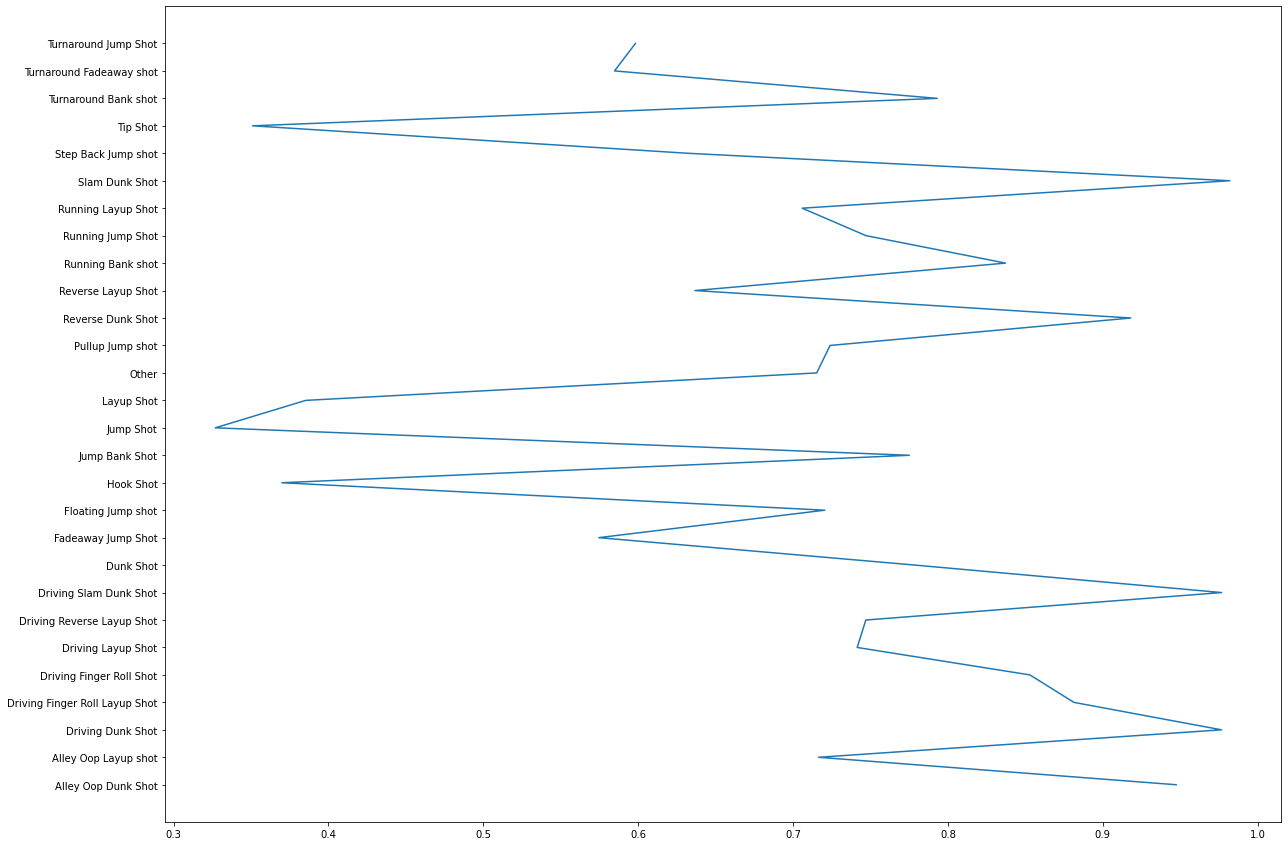

In [859]:
values, accuracy = accuracy_calc('action_type')
plt.figure(figsize=(20,15))
plt.plot(accuracy,values)
plt.show()

In [860]:
# # переведем ее в значения 0 и 1, добавив столбцы с соответствующими названиями
data = pd.get_dummies( data, columns = [ 'action_type' ] )

#### 2. combined_shot_type
Очевидно, это группа видов бросков, кажется в ней нет необходимости, поскольку мы оставляем более точные данные из 'action_type', не будем использовать.

In [861]:
data['combined_shot_type'].value_counts()

Jump Shot    19710
Layup         4532
Dunk          1056
Tip Shot       152
Hook Shot      127
Bank Shot      120
Name: combined_shot_type, dtype: int64

#### 3. game_id и game_event_id

game_id - это просто идентификатор игры, он не добавляет ценности. Game_event_id сам по себе также мало что значит (возможно только коррелирует с временем с начала матча).

Однако можно посчитать порядковый номер события в рамках одной игры, возможно это будет влиять на результативность (например, чем больше было действий перед броском, тем выше усталось).


In [862]:
# Воспользуемся тем, что значения отсортированы по game_id.
# Сделаем функцию, которая будет инкрементировать счетчик игрового события и обнулять его для каждой новой игры 
event_counter = 0
current_gameid = 0

def update_counter(row):
    global event_counter
    global current_gameid
    
    if row['game_id'] != current_gameid:
        current_gameid = row['game_id']
        event_counter = 0
        
    event_counter += 1
    return event_counter

# Создадим новое поле game_event_number, в котором будет храниться порядковый номер броска за игру
data['game_event_number'] = data.apply(update_counter, axis=1)


Диаграмма ниже показывает, что есть тренд на снижение результативности по мере роста числа бросков за игру. Имеются некоторые выбросы при больших значениях параметра, но таких записей совсем немного (всего 60 бросков с номерами 33+ из 25697). Есть смысл оставить этот новый параметр.

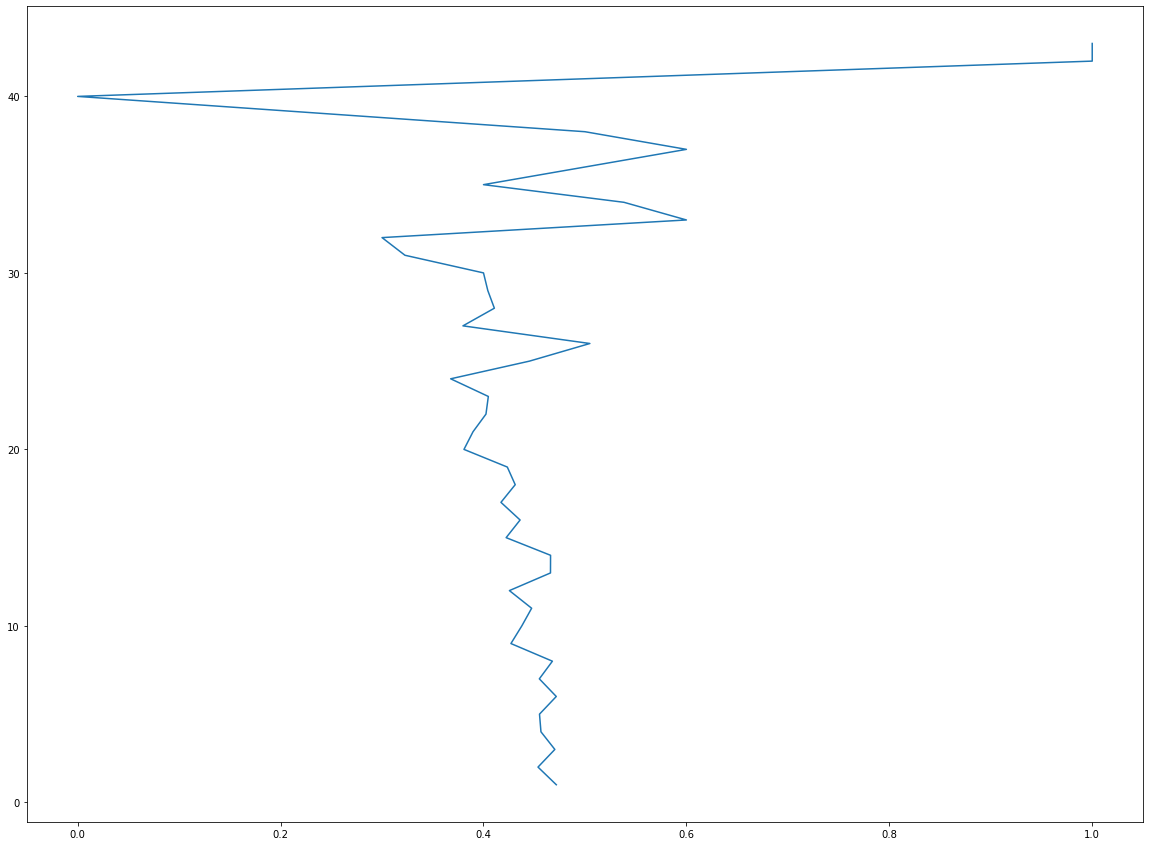

In [863]:
values, accuracy = accuracy_calc('game_event_number')
plt.figure(figsize=(20,15))
plt.plot(accuracy,values)
plt.show()

#### 4. Параметры положения на площадке во время броска

1) Координаты lat (latitude) и lon (longitude) не представляют ценности для модели, не будем их использовать 

2) Координаты loc_x и loc_y как числа мало применимы для модели. Скорее нас интересует место на площадки, откуда производился бросок.

3) У нас есть дополнительные переменные (shot_type, shot_zone_area, shot_zone_basic, shot_zone_range), которые также соотносятся с зонами на площадке.

In [864]:
data['shot_type'].value_counts()

2PT Field Goal    20285
3PT Field Goal     5412
Name: shot_type, dtype: int64

In [865]:
data['shot_zone_area'].value_counts()

Center(C)                11289
Right Side Center(RC)     3981
Right Side(R)             3859
Left Side Center(LC)      3364
Left Side(L)              3132
Back Court(BC)              72
Name: shot_zone_area, dtype: int64

In [866]:
data['shot_zone_basic'].value_counts()

Mid-Range                10532
Restricted Area           5932
Above the Break 3         4720
In The Paint (Non-RA)     3880
Right Corner 3             333
Left Corner 3              240
Backcourt                   60
Name: shot_zone_basic, dtype: int64

In [867]:
data['shot_zone_range'].value_counts()

Less Than 8 ft.    7857
16-24 ft.          6907
8-16 ft.           5580
24+ ft.            5281
Back Court Shot      72
Name: shot_zone_range, dtype: int64

Визулизируем эти зоны:

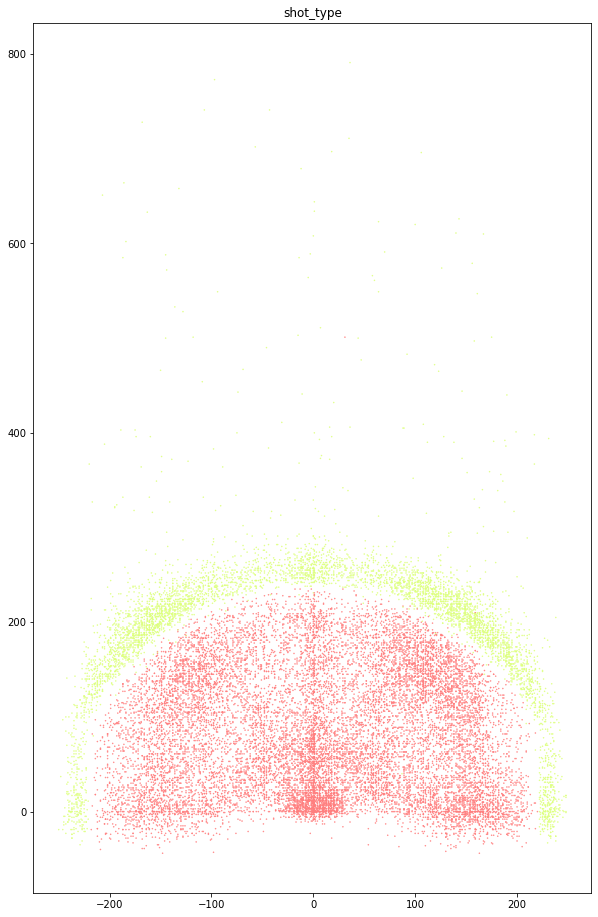

In [868]:
# Переменная shot_type
color_list = []
loc_x = data['loc_x']
loc_y = data['loc_y']

for shot_zone in data['shot_type']:
    if shot_zone == '2PT Field Goal':
        color_list.append('#FF7F7F')
    elif shot_zone == '3PT Field Goal':
        color_list.append('#DEFF7F')     
    else:
        color_list.append('black')

    
plt.figure(figsize=(10,16))
plt.scatter(loc_x, loc_y, 0.25, color_list)
plt.title("shot_type")
plt.show()


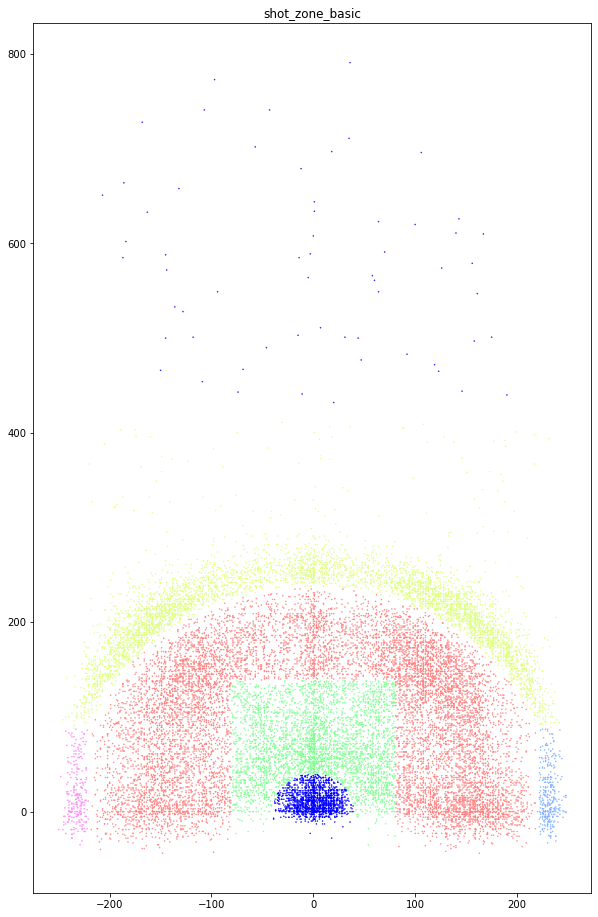

In [869]:
# Переменная shot_zone_basic
color_list = []
loc_x = data['loc_x']
loc_y = data['loc_y']

for shot_zone in data['shot_zone_basic']:
    if shot_zone == 'Mid-Range':
        color_list.append('#FF7F7F')
    elif shot_zone == 'Restricted Area':
        color_list.append('blue')
    elif shot_zone == 'Above the Break 3':
        color_list.append('#DEFF7F')        
    elif shot_zone == 'In The Paint (Non-RA)':
        color_list.append('#7FFF91')        
    elif shot_zone == 'Right Corner 3':
        color_list.append('#7FB0FF')        
    elif shot_zone == 'Left Corner 3':
        color_list.append('#FF7FF5')        
    elif shot_zone == 'Backcourt':
        color_list.append('#0009FD')        
    else:
        color_list.append('white')

    
plt.figure(figsize=(10,16))
plt.scatter(loc_x, loc_y, 0.25, color_list)
plt.title("shot_zone_basic")
plt.show()


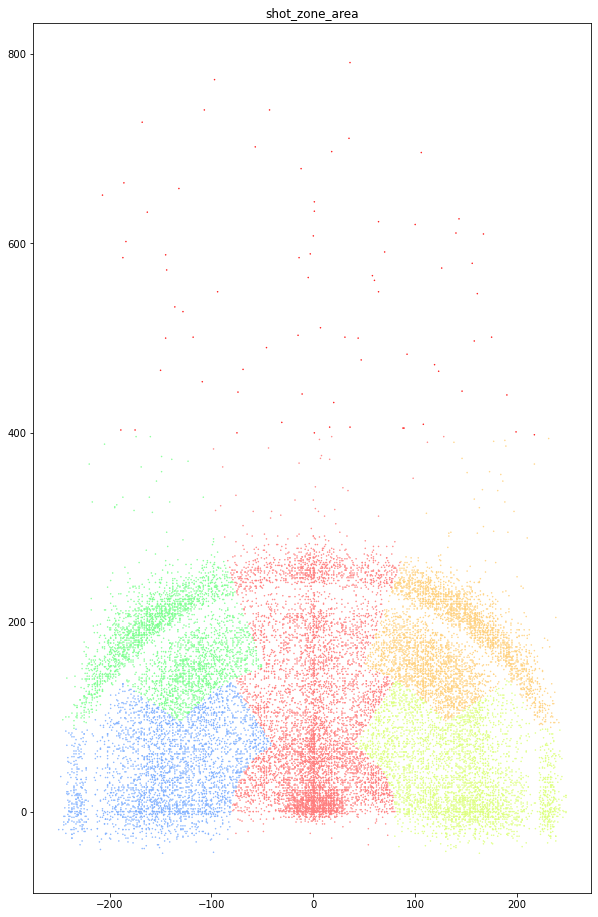

In [870]:
# Переменная shot_zone_area
color_list = []
loc_x = data['loc_x']
loc_y = data['loc_y']

for shot_zone in data['shot_zone_area']:
    if shot_zone == 'Center(C)':
        color_list.append('#FF7F7F')
    elif shot_zone == 'Right Side Center(RC)':
        color_list.append('#FFD27F')
    elif shot_zone == 'Right Side(R)':
        color_list.append('#DEFF7F')        
    elif shot_zone == 'Left Side Center(LC)':
        color_list.append('#7FFF91')        
    elif shot_zone == 'Left Side(L)':
        color_list.append('#7FB0FF')        
    elif shot_zone == 'Back Court(|BC)':
        color_list.append('#FF7FF5')           
    else:
        color_list.append('red')

plt.figure(figsize=(10,16))
plt.scatter(loc_x, loc_y, 0.25, color_list)
plt.title("shot_zone_area")
plt.show()

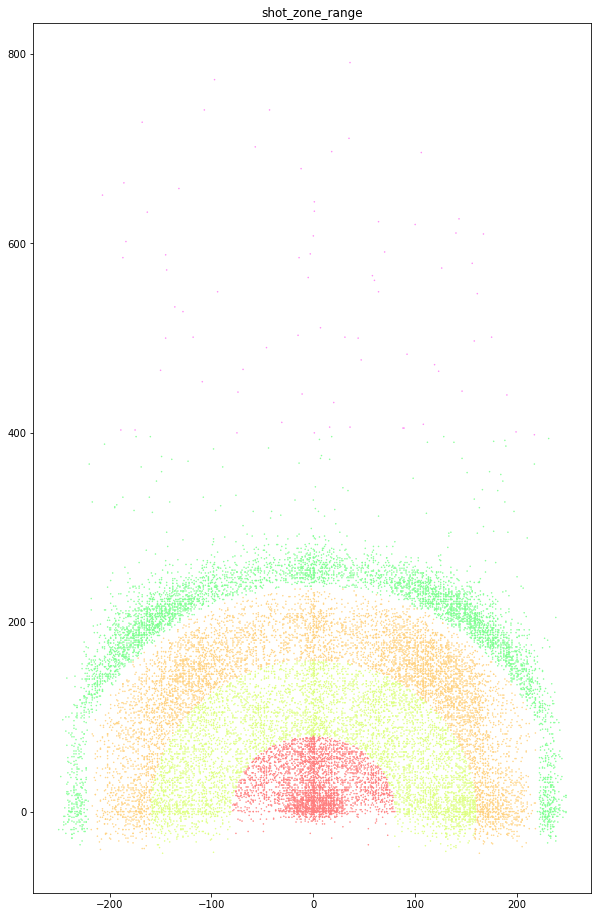

In [871]:
# Переменная shot_zone_range
color_list = []
loc_x = data['loc_x']
loc_y = data['loc_y']

for shot_zone in data['shot_zone_range']:
    if shot_zone == 'Less Than 8 ft.':
        color_list.append('#FF7F7F')
    elif shot_zone == '16-24 ft.':
        color_list.append('#FFD27F')
    elif shot_zone == '8-16 ft.':
        color_list.append('#DEFF7F')        
    elif shot_zone == '24+ ft.':
        color_list.append('#7FFF91')        
    elif shot_zone == 'Back Court Shot':
        color_list.append('#FF7FF5')                 
    else:
        color_list.append('red')

plt.figure(figsize=(10,16))
plt.scatter(loc_x, loc_y, 0.25, color_list)
plt.title("shot_zone_range")
plt.show()

Очевидно, что все эти зоны имеют разный уровень результативности (пример - см. ниже), каждый из этих параметров несет какую-то информацию. Но есть ощущение, что при использовании какого-то одного параметра мы получим недостаточную точность.

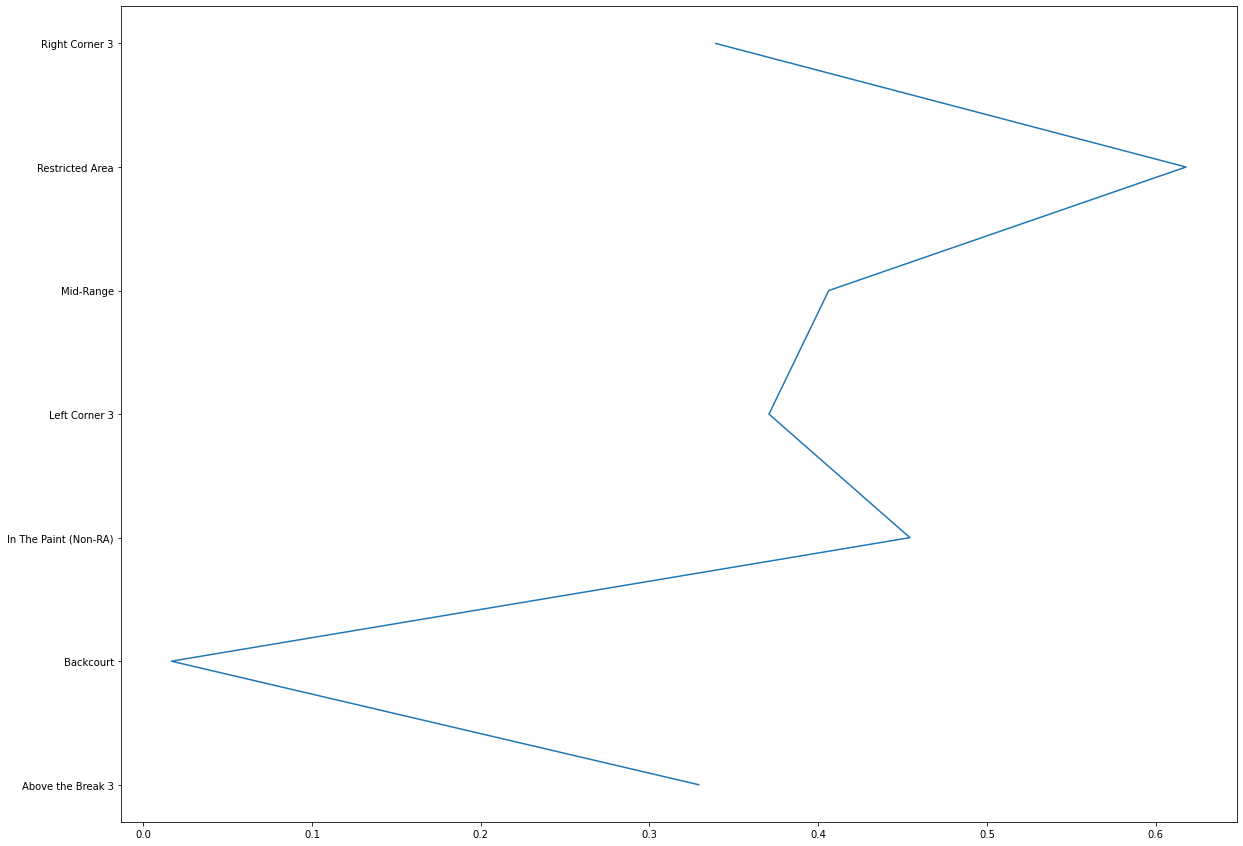

In [872]:
values, accuracy = accuracy_calc('shot_zone_basic')
plt.figure(figsize=(20,15))
plt.plot(accuracy,values)
plt.show()

Вероятно правильнее было бы использовать "кусочки" площадки, образующиеся на пересечении этих зон.
Но вычислять их довольно сложно, поэтому думаю, что можно разбить всю площадку на отдельные зоны размером 50х50 с помощью координатной сетки.

In [873]:
#Функция для определения зоны по направлению X
def get_loc_x_quadrant(loc_x):
    if loc_x >= 200:
        return "J"
    if loc_x >= 150 and loc_x < 200:
        return "I"
    if loc_x >= 100 and loc_x < 150:
        return "H"
    if loc_x >= 50 and loc_x < 100:
        return "G"
    if loc_x >= 0 and loc_x < 50:
        return "F"
    if loc_x >= -50 and loc_x < 0:
        return "E"
    if loc_x >= -100 and loc_x < -50:
        return "D"
    if loc_x >= -150 and loc_x < -100:
        return "C"
    if loc_x >= -200 and loc_x < -150:
        return "B"
    if loc_x < -200:
        return "A"

#Функция для определения зоны по направлению Y
def get_loc_y_quadrant(loc_y):
    if loc_y < 0:
        return "1"
    if loc_y >= 0 and loc_y < 50:
        return "2"
    if loc_y >= 50 and loc_y < 100:
        return "3"
    if loc_y >= 100 and loc_y < 150:
        return "4"
    if loc_y >= 150 and loc_y < 200:
        return "5"
    if loc_y >= 200 and loc_y < 250:
        return "6"
    if loc_y >= 250 and loc_y < 300:
        return "7"
    if loc_y >= 300:
        return "8"

#Функция для определения точного квадрата
def get_loc_quadrant(row):
    loc_x_quadrant = get_loc_x_quadrant(row['loc_x'])
    loc_y_quadrant = get_loc_y_quadrant(row['loc_y'])
    if loc_y_quadrant == "8":
        return "X8"
    else:
        return loc_x_quadrant + loc_y_quadrant

# Добавим соответствующий признак в данные
data['loc_quadrant'] = data.apply(get_loc_quadrant, axis=1)
data

,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,...,action_type_Running Jump Shot,action_type_Running Layup Shot,action_type_Slam Dunk Shot,action_type_Step Back Jump shot,action_type_Tip Shot,action_type_Turnaround Bank shot,action_type_Turnaround Fadeaway shot,action_type_Turnaround Jump Shot,game_event_number,loc_quadrant
1,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,...,0,0,0,0,0,0,0,0,1,B2
2,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,...,0,0,0,0,0,0,0,0,2,C4
3,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,...,0,0,0,0,0,0,0,0,3,H5
4,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,...,0,0,0,0,0,0,0,0,4,F2
5,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,0,...,0,0,0,0,0,0,0,0,5,C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30691,Layup,382,49900088,34.0443,0,0,-118.2698,7,4,1,...,0,0,0,0,0,0,0,0,19,F2
30692,Jump Shot,397,49900088,33.9963,1,48,-118.2688,6,4,1,...,0,0,0,0,0,0,0,0,20,F2
30694,Jump Shot,426,49900088,33.8783,-134,166,-118.4038,3,4,1,...,1,0,0,0,0,0,0,0,21,C5
30695,Jump Shot,448,49900088,33.7773,31,267,-118.2388,2,4,1,...,0,0,0,0,0,0,0,0,22,F7


Оценим влияние положения на сетке на результативность - очевидно, вариативность очень высокая.

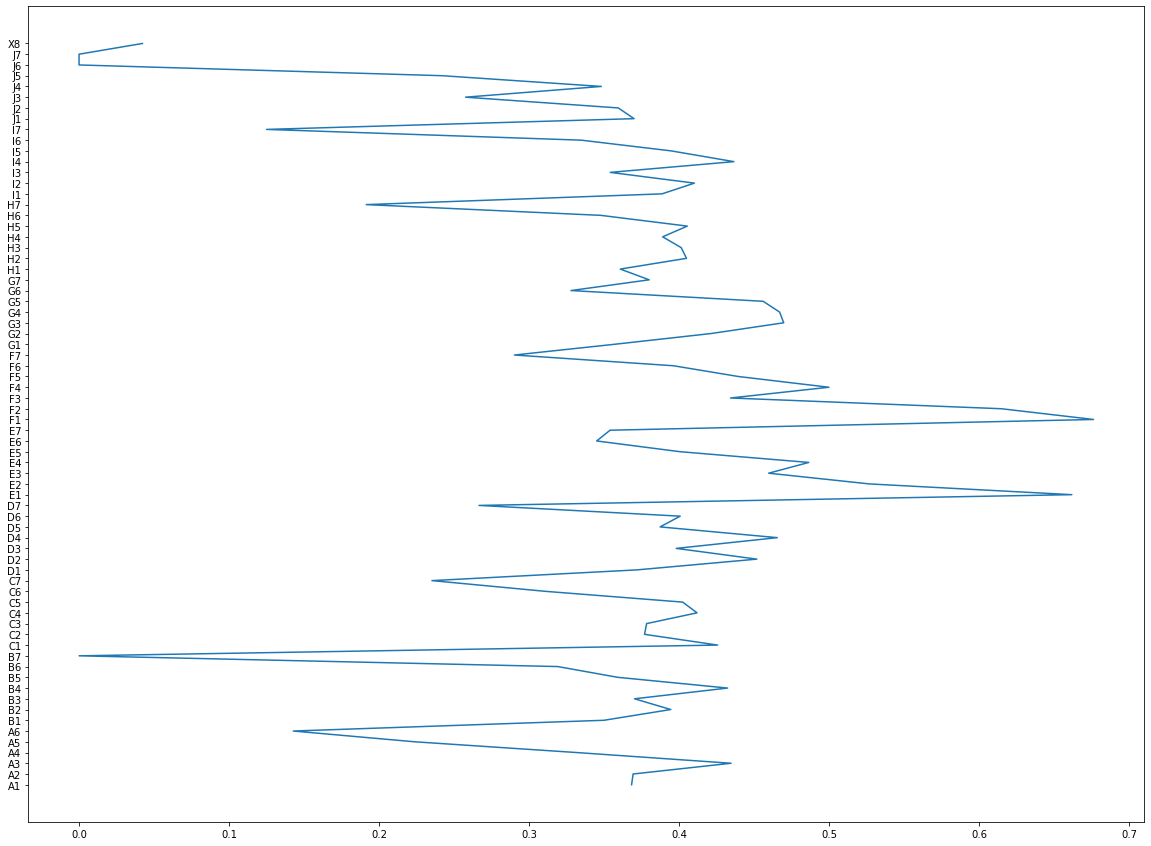

In [874]:
values, accuracy = accuracy_calc('loc_quadrant')
plt.figure(figsize=(20,15))
plt.plot(accuracy,values)
plt.show()

In [875]:
# Добавим соответствующие поля, чтобы преобразовать этот новый категориальный признак
data = pd.get_dummies( data, columns = [ 'loc_quadrant' ] )

4) shot_distance - также влияет на результативность. Но наш новый признак положения на площадки должен давать лучший результат. Пока не будем использовать, можно вернуться к этому признаку позже при необходимости.

##### 5. minutes remaining, seconds remaining, period

Это информация об оставшихся минутах и секундах до конца периода, а также о текущем периоде.

Как видно, средняя точность варьируется от периоду к периоду:

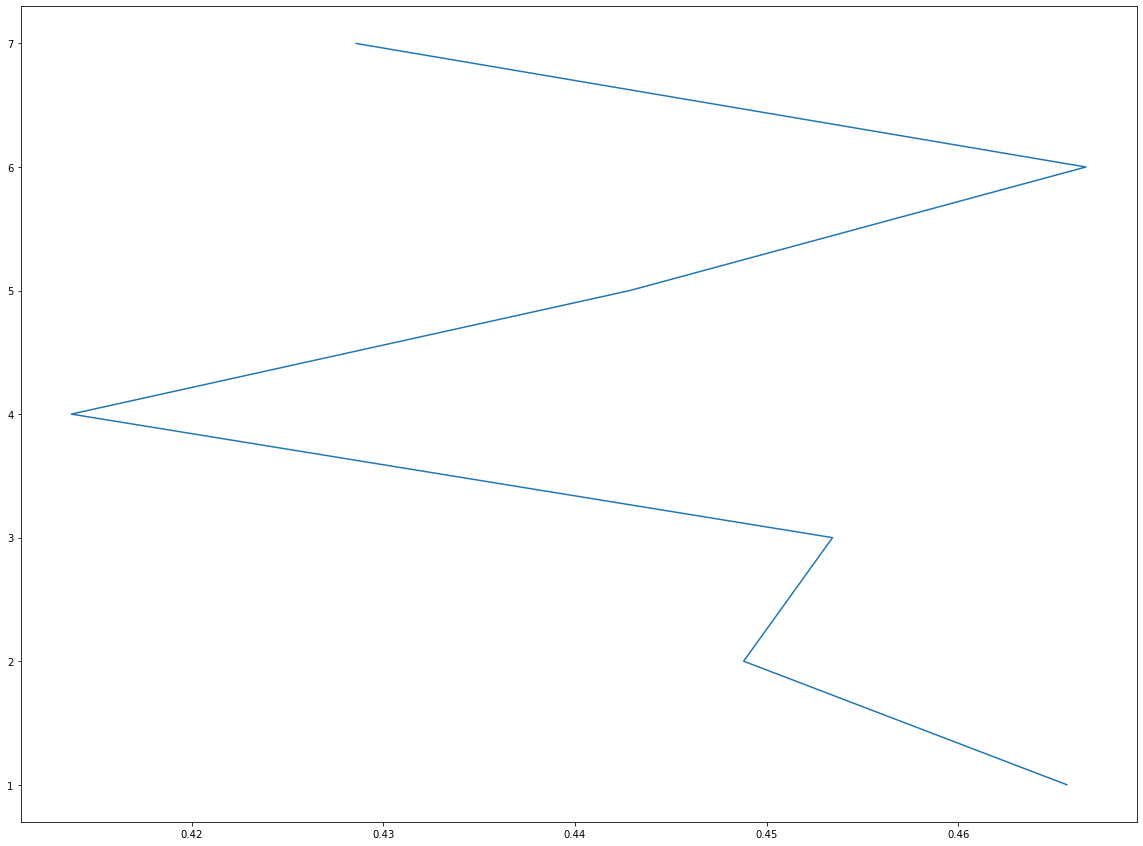

In [876]:
values, accuracy = accuracy_calc('period')
plt.figure(figsize=(20,15))
plt.plot(accuracy,values)
plt.show()

Но мы можем на основе всех трех параметров сделать более точный, сквозной показатель: число минут с начала матча

In [877]:
#Функция для подсчета количества минут с начала матча
def get_time_slot(row):
    if row['period'] <= 4:
        return ((row['period'] - 1)* 12 + (12 - row['minutes_remaining']))
    else:
        return (48 + (row['period'] - 5)* 5 + (5 - row['minutes_remaining']))

# Добавим соответствующий признак в данные    
data['minutes_passed'] = data.apply(get_time_slot, axis=1)

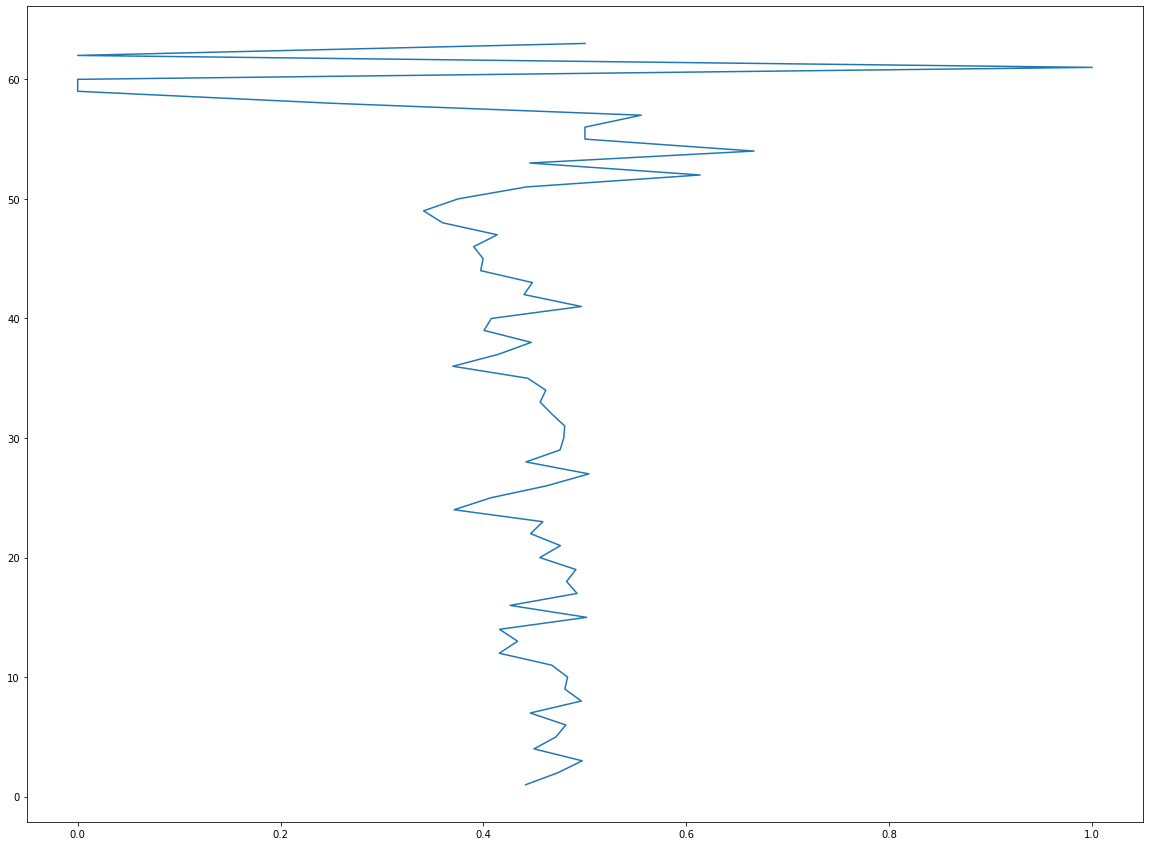

In [878]:
values, accuracy = accuracy_calc('minutes_passed')
plt.figure(figsize=(20,15))
plt.plot(accuracy,values)
plt.show()

##### 6. playoffs
В этом поле содержится информация о том, проводилась данная игра в рамках серии плей-офф. Значения '1' и '0' нас устраивают, оставляем все как есть (хотя большого влияния на результативность этот параметр не оказывает)

In [879]:
data['playoffs'].value_counts()

0    21939
1     3758
Name: playoffs, dtype: int64

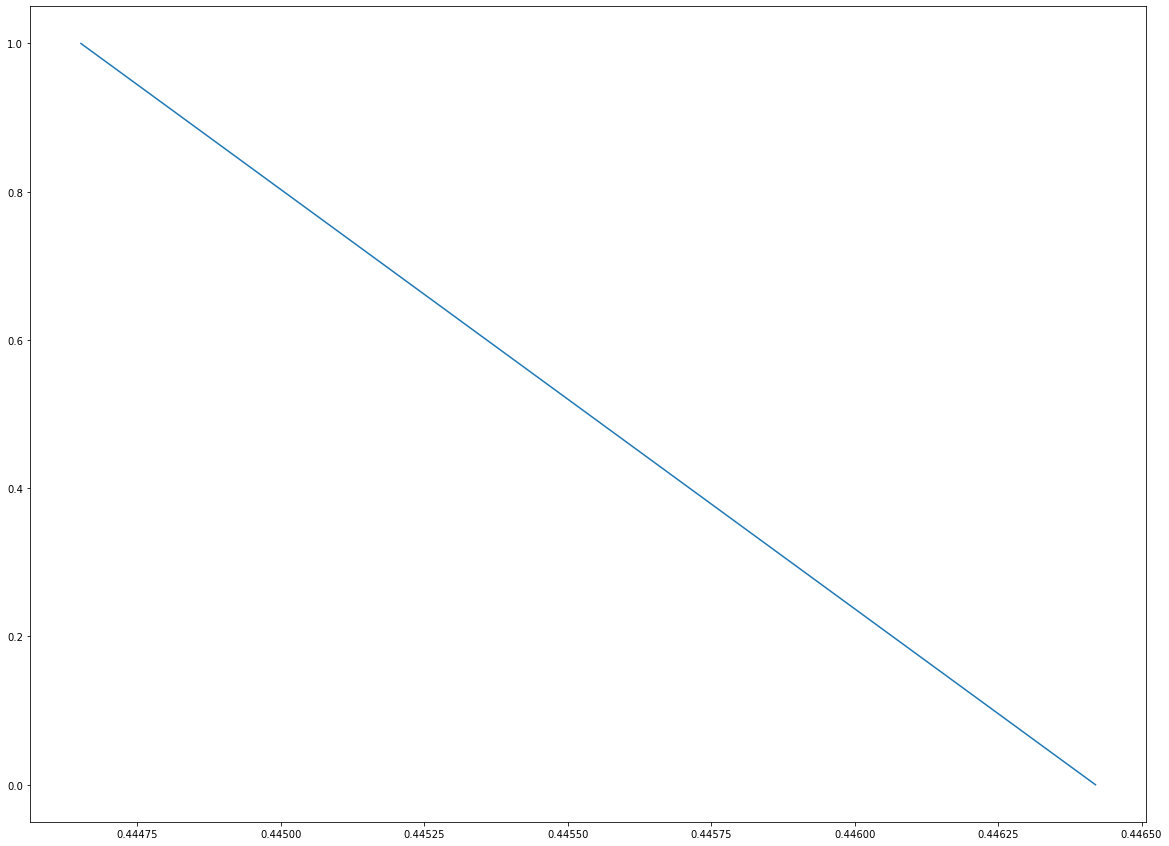

In [880]:
values, accuracy = accuracy_calc('playoffs')
plt.figure(figsize=(20,15))
plt.plot(accuracy,values)
plt.show()

##### 7. season
В поле season содержится информация о сезоне, в котором проходила игра (например, 2010-2011 годы). Но у нас уже есть более точная информация (год и месяц), вероятно, сезон не добавит новой информации, не будем использовать его.

In [881]:
data['season'].value_counts()

2005-06    1924
2002-03    1852
2008-09    1851
2007-08    1819
2009-10    1772
2001-02    1708
2006-07    1579
2000-01    1575
2010-11    1521
2011-12    1416
2003-04    1371
2012-13    1328
1999-00    1312
2004-05    1127
2015-16     932
1997-98     810
1998-99     765
2014-15     593
1996-97     383
2013-14      59
Name: season, dtype: int64

#### 8. team_id, team_name
Всегда обозначают одну команду - Los Angeles Lakers, не будем использовать

#### 9. game_date
У нас более 1500 дат в этом поле (соответствует числу игр). Каждая отдельная дата не имеет ценности для модели, но мы можем из даты извлечь например месяц и год и проверить, будет ли какое-то влияние на результативность.

In [882]:
data['game_date'].value_counts()

2016-04-13    43
2007-03-30    41
2006-01-22    39
2002-11-07    39
2008-01-14    37
              ..
1997-02-21     1
1997-04-25     1
1997-05-06     1
1997-02-28     1
1998-05-12     1
Name: game_date, Length: 1558, dtype: int64

In [883]:
#Функция для определения года
def get_year(row):
    return datetime.strptime(row['game_date'], '%Y-%m-%d').year

# Добавим соответствующий признак в данные
data['game_year'] = data.apply(get_year, axis=1)

In [884]:
#Функция для определения месяца
def get_month(row):
    return datetime.strptime(row['game_date'], '%Y-%m-%d').month

# Добавим соответствующий признак в данные
data['game_month'] = data.apply(get_month, axis=1)

Видим, что есть зависимость результативности от года и месяца, преобразуем эти категориальные признаки с помощью OneHotEncoder

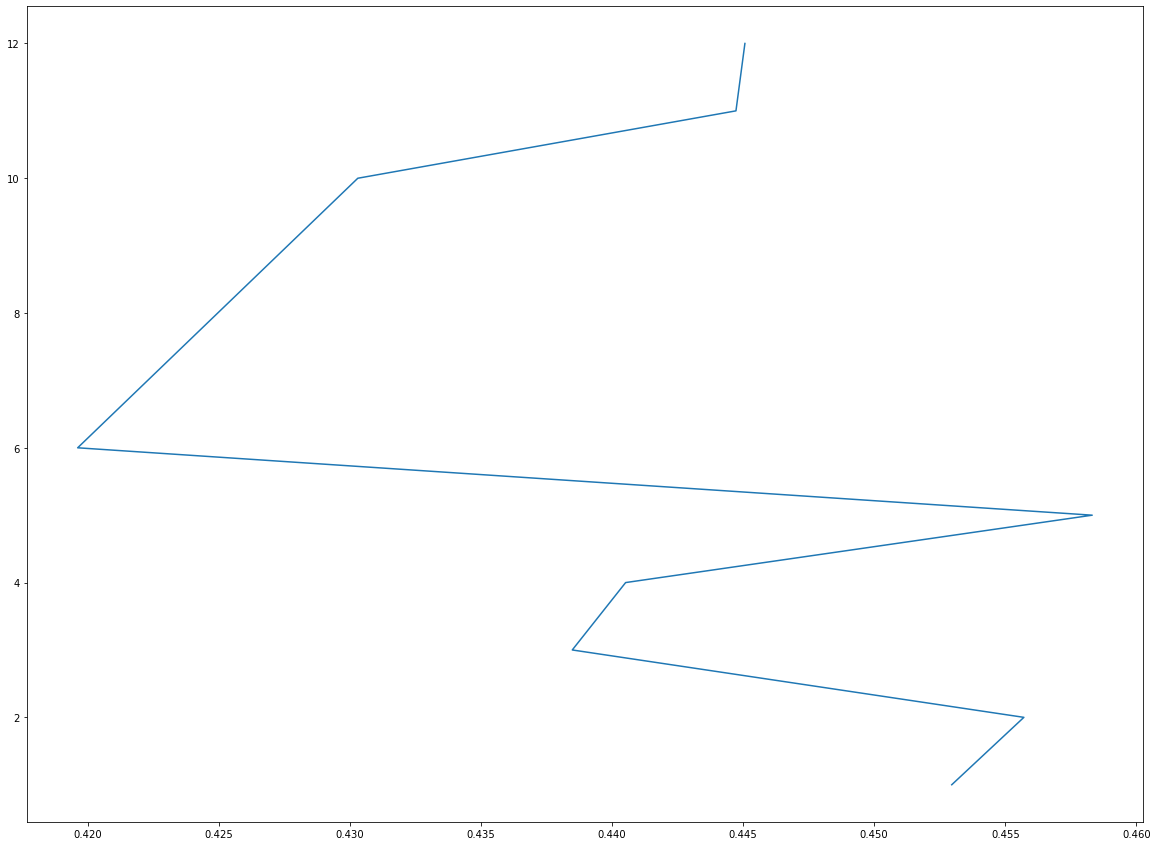

In [885]:
values, accuracy = accuracy_calc('game_month')
plt.figure(figsize=(20,15))
plt.plot(accuracy,values)
plt.show()

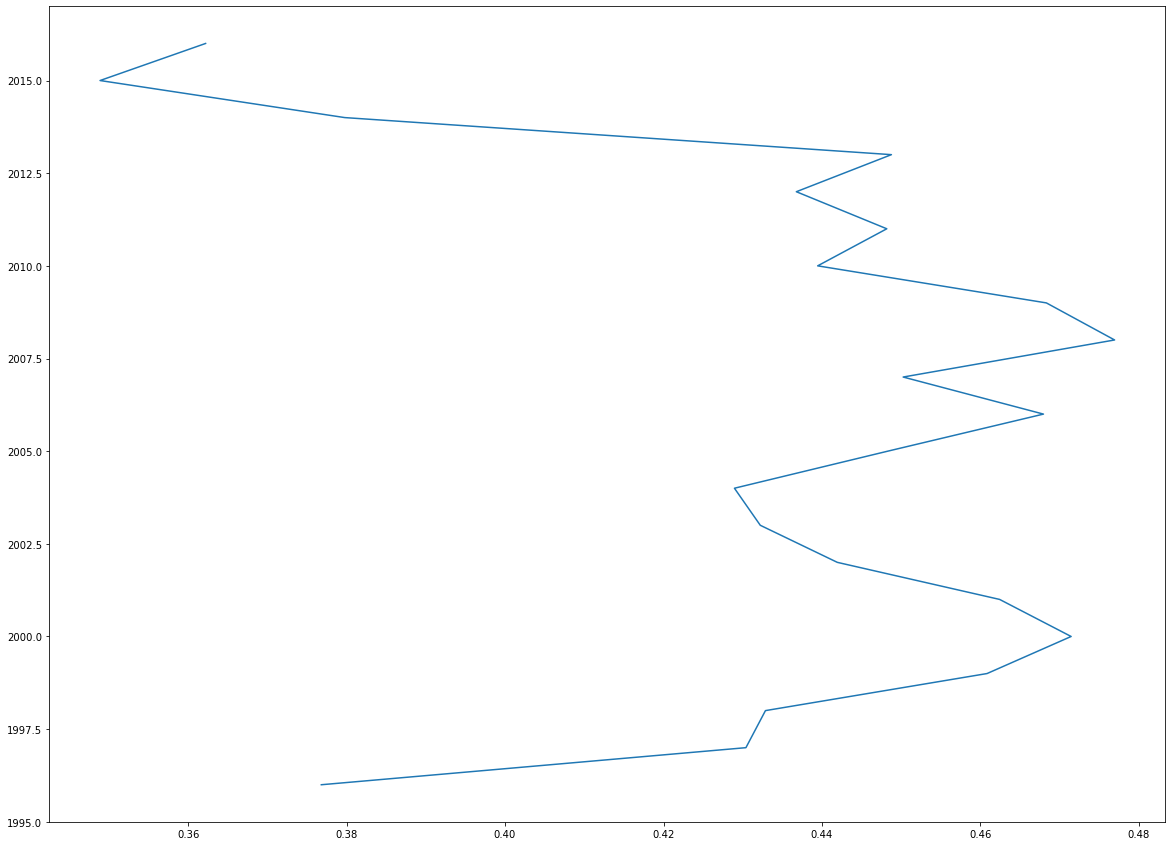

In [886]:
values, accuracy = accuracy_calc('game_year')
plt.figure(figsize=(20,15))
plt.plot(accuracy,values)
plt.show()

In [887]:
# Добавим соответствующие поля, чтобы преобразовать эти новые категориальные признаки
data = pd.get_dummies( data, columns = [ 'game_year' ] )
data = pd.get_dummies( data, columns = [ 'game_month' ] )

##### 10. matchup
В поле matchup содержится информация о том, была ли игра дома или в гостях. Обработаем данные и добавим соответствующий признак

In [888]:
data['matchup'].value_counts()

LAL @ SAS      853
LAL vs. SAS    765
LAL @ PHX      751
LAL @ SAC      751
LAL vs. HOU    722
              ... 
LAL @ PHO       29
LAL vs. NOP     21
LAL vs. SAN     20
LAL @ UTH       15
LAL vs. BKN     13
Name: matchup, Length: 74, dtype: int64

In [889]:
#Функция для определения домашнего матча
def get_homegame(row):
    if 'vs.' in row['matchup']:
        return 1
    else:
        return 0

# Добавим соответствующий признак в данные
data['homegame'] = data.apply(get_homegame, axis=1)

##### 11. opponent
Проверим, что результативность зависит от команды-соперника. Добавим соответствующие признаки в модель.

In [890]:
data['opponent'].value_counts()

SAS    1638
PHX    1535
HOU    1399
SAC    1397
DEN    1352
POR    1292
UTA    1238
MIN    1219
GSW    1143
LAC    1074
DAL    1033
MEM     871
BOS     783
SEA     694
IND     626
ORL     604
PHI     603
DET     587
NYK     566
OKC     561
TOR     556
MIA     517
CHI     516
CLE     514
MIL     507
WAS     501
CHA     500
NOH     475
ATL     438
NJN     422
NOP     287
VAN     204
BKN      45
Name: opponent, dtype: int64

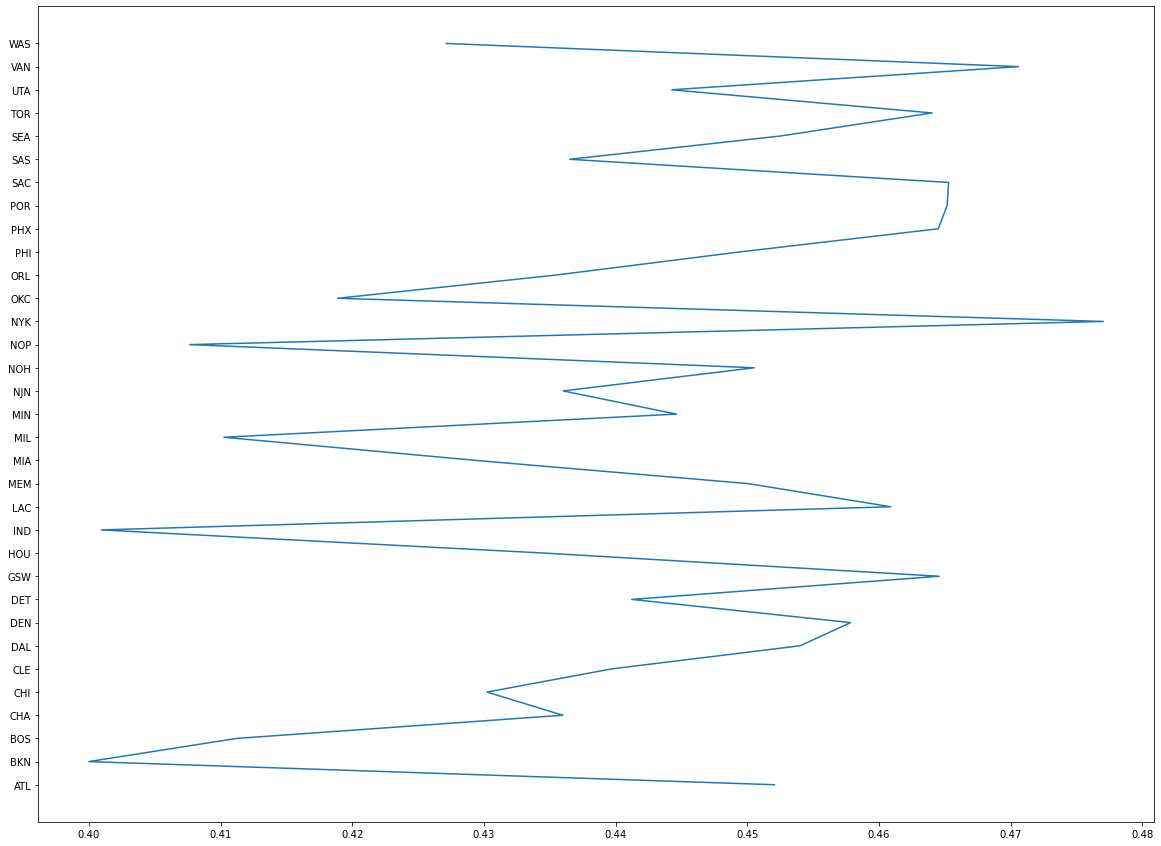

In [891]:
values, accuracy = accuracy_calc('opponent')
plt.figure(figsize=(20,15))
plt.plot(accuracy,values)
plt.show()

In [892]:
data = pd.get_dummies( data, columns = [ 'opponent' ] )

In [894]:
del data['shot_id']
del data['combined_shot_type']
del data['game_event_id']
del data['game_id']
del data['lat']
del data['loc_x']
del data['loc_y']
del data['lon']
del data['minutes_remaining']
del data['seconds_remaining']
del data['period']
del data['season']
del data['shot_distance']
del data['shot_type']
del data['shot_zone_area']
del data['shot_zone_basic']
del data['shot_zone_range']
del data['team_id']
del data['team_name']
del data['matchup']
del data['game_date']

In [895]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 166 columns):
 #   Column                                      Dtype  
---  ------                                      -----  
 0   playoffs                                    int64  
 1   shot_made_flag                              float64
 2   action_type_Alley Oop Dunk Shot             uint8  
 3   action_type_Alley Oop Layup shot            uint8  
 4   action_type_Driving Dunk Shot               uint8  
 5   action_type_Driving Finger Roll Layup Shot  uint8  
 6   action_type_Driving Finger Roll Shot        uint8  
 7   action_type_Driving Layup Shot              uint8  
 8   action_type_Driving Reverse Layup Shot      uint8  
 9   action_type_Driving Slam Dunk Shot          uint8  
 10  action_type_Dunk Shot                       uint8  
 11  action_type_Fadeaway Jump Shot              uint8  
 12  action_type_Floating Jump shot              uint8  
 13  action_type_Hook Shot         

In [754]:
data

,playoffs,shot_made_flag,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,action_type_Driving Dunk Shot,action_type_Driving Finger Roll Layup Shot,action_type_Driving Finger Roll Shot,action_type_Driving Layup Shot,action_type_Driving Reverse Layup Shot,action_type_Dunk Shot,...,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
1,0,0.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,1.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,1.0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30691,1,0.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
30692,1,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30694,1,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30695,1,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [896]:
X = data.drop('shot_made_flag', axis=1)  
y = data['shot_made_flag'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2020, stratify=y)

In [898]:
# model = LinearRegression()
model = LogisticRegression(max_iter=700)

model.fit(X_train, y_train)
print(model.score(X_train, y_train))

0.683549229999444


In [899]:
y_pred = model.predict(X_test)

conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
display('Logistic Regression recall score', recall_score(y_test, y_pred))        

,predicted 0,predicted 1
actual 0,3667,603
actual 1,1869,1571


'Logistic Regression recall score'

0.4566860465116279

In [900]:
model = LogisticRegression(
    penalty='l2',
    solver='liblinear')

model.fit(X_train, y_train)
print(model.score(X_train, y_train))

0.6836048257074554


In [901]:
y_pred = model.predict(X_test)

conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
display('Logistic Regression recall score', recall_score(y_test, y_pred))        

,predicted 0,predicted 1
actual 0,3667,603
actual 1,1868,1572


'Logistic Regression recall score'

0.4569767441860465

In [902]:
model = RidgeClassifier()

model.fit(X_train, y_train)
print(model.score(X_train, y_train))

0.6838272085395007


In [903]:
y_pred = model.predict(X_test)

conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
display('Logistic Regression recall score', recall_score(y_test, y_pred))        

,predicted 0,predicted 1
actual 0,3663,607
actual 1,1866,1574


'Logistic Regression recall score'

0.4575581395348837

In [904]:
model = RandomForestClassifier(n_estimators=100,max_depth=8,max_features=20,criterion='gini',bootstrap=True)
model.fit(X_train,y_train)
# scores = cross_val_score(best_model, X_train, y_train, cv=kfold, scoring='neg_log_loss')
# scores_acc = cross_val_score(best_model, X, Y, cv=kfold, scoring='accuracy')
print(model.score(X_train, y_train))

0.6810474231389336


In [905]:
y_pred = model.predict(X_test)

conf_matrix_baseline = pd.DataFrame(confusion_matrix(y_test, y_pred), index = ['actual 0', 'actual 1'], columns = ['predicted 0', 'predicted 1'])
display(conf_matrix_baseline)
display('Logistic Regression recall score', recall_score(y_test, y_pred))        

,predicted 0,predicted 1
actual 0,3599,671
actual 1,1812,1628


'Logistic Regression recall score'

0.47325581395348837

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 10)
XPCAreduced = pca.fit_transform(np.transpose(X))